---

# <center>Tweet Sentiment Analysis 

<center> <img src="https://raw.githubusercontent.com/Masterx-AI/Project_Twitter_Sentiment_Analysis_/main/twitt.jpg" style="width: 700px; align:center"/>

---

## 1. Data Exploration

In [1]:
#Importing the necessary librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('Tweets.csv', header=0)
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative



Inference: The Datset consists of 2 features & 27481 samples.


In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [4]:
#Checking the stats of all the columns

display(df.describe())

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

## 2. Data Preprocessing

In [5]:
#Check for empty elements

print(df.isnull().sum())

text         1
sentiment    0
dtype: int64


**Inference:** Since the dataset has one null element, let us just drop it.

In [6]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [7]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [8]:
#Filtering the text

import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PMLS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 27480/27480 [00:13<00:00, 2015.62it/s]


,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put releas alreadi bought,negative


In [9]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

# Define tokenizer functions
porter = PorterStemmer()
def tokenizer(text):
    return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, use_idf=True, norm='l2', smooth_idf=True)

# Fit the TfidfVectorizer to your data
y = df[target].values
x = tfidf.fit_transform(df.text)

# Save the TfidfVectorizer to a file
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

---

In [10]:
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## 3. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


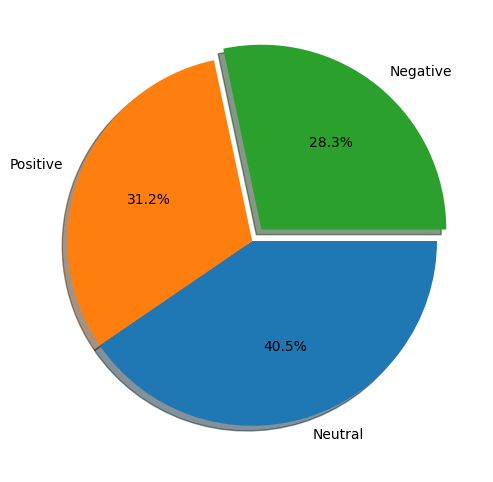

In [11]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True,
        explode=[0,0,0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

**Inference:** The Target Variable seems to be slightly imbalanced!

100%|██████████| 27480/27480 [00:06<00:00, 4494.66it/s]


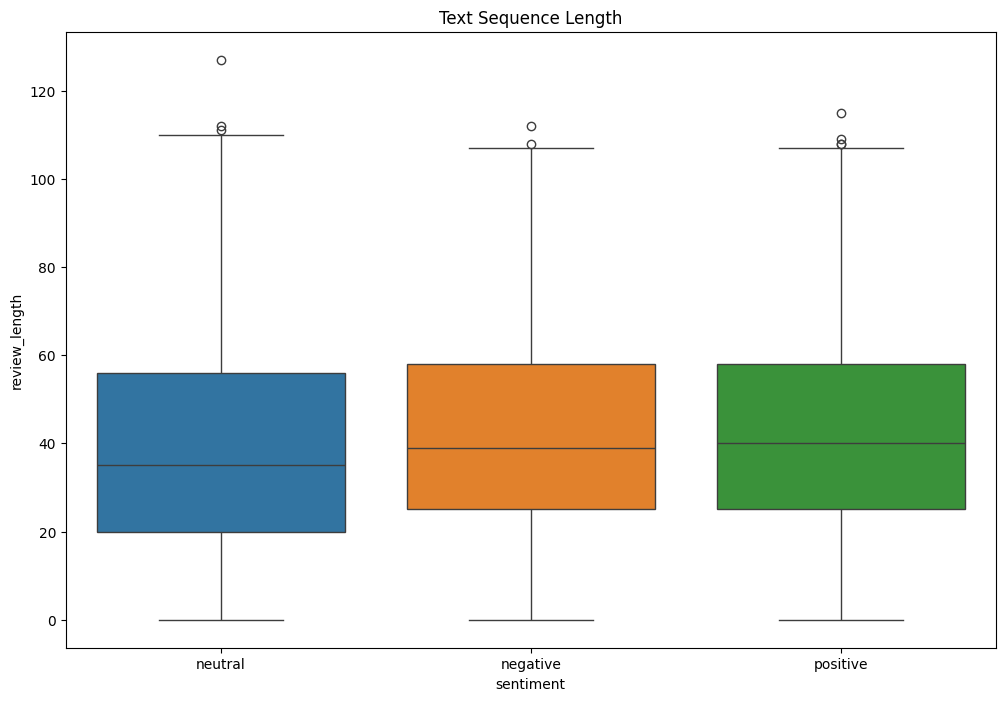

In [12]:
# Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[12,8])
sns.boxplot(x=target,y='review_length', data=df2, hue=target)
plt.title('Text Sequence Length')
plt.show()

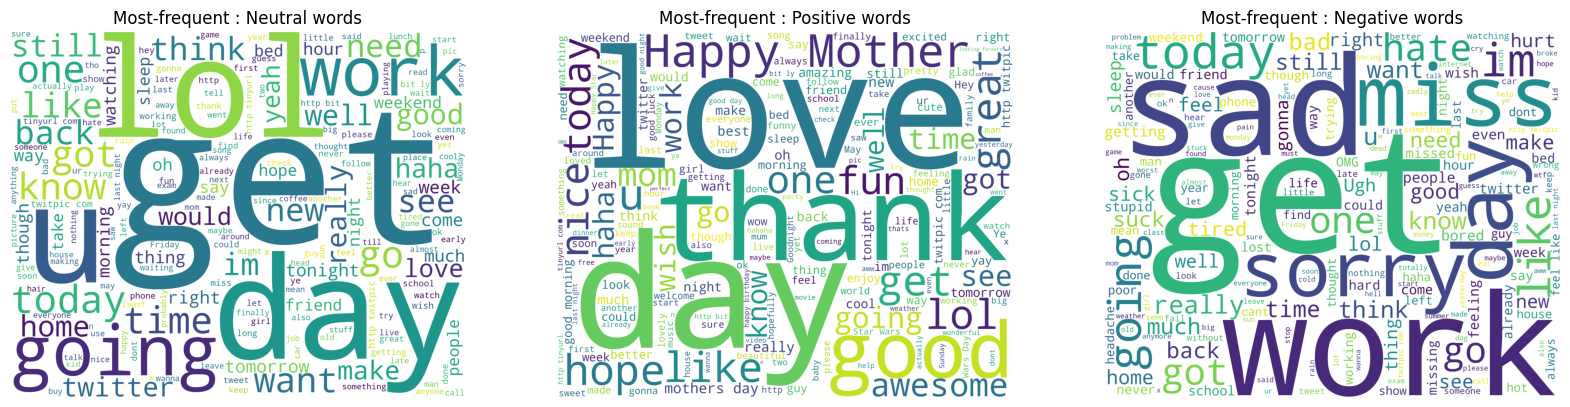

In [13]:
#Visualising the

neutraldata = original_df[original_df[target]=='neutral']
neutraldata= neutraldata['text']
positivedata = original_df[original_df[target]=='positive']
positivedata =positivedata['text']
negdata = original_df[original_df[target]== 'negative']
negdata = negdata['text']


def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neutraldata,'white','Most-frequent : Neutral words')

plt.subplot(1,3,2)
wordcloud_draw(positivedata,'white','Most-frequent : Positive words')

plt.subplot(1,3,3)
wordcloud_draw(negdata, 'white','Most-frequent : Negative words')
plt.show()

---

## 4. Predictive Modeling

In [14]:
# Assigning labels to target variable

MAP={'negative':0, 'neutral':1, 'positive':2}
df.sentiment = df.sentiment.map(MAP)

In [15]:
#Splitting the data intro training & testing sets

X = x
Y = pd.Series(y).map(MAP)
MAP={'negative':0, 'neutral':1, 'positive':2}
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,len(Y),'\nTraining set  ---> ',Train_X.shape,len(Train_Y),'\nTesting set   ---> ', Test_X.shape,'', len(Test_Y))

Original set  --->  (27480, 22569) 27480 
Training set  --->  (21984, 22569) 21984 
Testing set   --->  (5496, 22569)  5496


In [16]:
#Let us create first create a table to store the results of various models

Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)

# Classification Summary Function
def Classification_Summary(pred, pred_prob, i,model):
    Evaluation_Results.iloc[i]['Accuracy'] = round(accuracy_score(Test_Y, pred), 3) * 100
    Evaluation_Results.iloc[i]['Precision'] = round(precision_score(Test_Y, pred, average='weighted'), 3) * 100
    Evaluation_Results.iloc[i]['Recall'] = round(recall_score(Test_Y, pred, average='weighted'), 3) * 100
    Evaluation_Results.iloc[i]['F1-score'] = round(f1_score(Test_Y, pred, average='weighted'), 3) * 100
    Evaluation_Results.iloc[i]['AUC-ROC score'] = round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'), 3) * 100

    # print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3, '-'*35, Evaluation_Results.index[i], '-'*35, '>'*3))
    # print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred), 3) * 100))
    # print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'), 3) * 100))
    # print('\n \033[1mConfusion Matrix:\033[0m\n', confusion_matrix(Test_Y, pred))
    # print('\n\033[1mClassification Report:\033[0m\n', classification_report(Test_Y, pred))

    plot_roc_curve(Test_Y, pred_prob,model)

def plot_roc_curve(Test_Y, pred_prob,model):
    # One-vs-Rest (OvR) ROC AUC for each class
    n_classes = len(set(Test_Y))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Test_Y, pred_prob[:, i], pos_label=i)
        roc_auc[i] = roc_auc_score(Test_Y == i, pred_prob[:, i])

        plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i] * 100))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'{model}.jpg')
    plt.show()

# Visualising Function
def AUC_ROC_plot(Test_Y, pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area = {:.2f})'.format(ref_auc * 100))
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model (area = {:.2f})'.format(lr_auc * 100))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [18]:
def print_report(pred):
    report = classification_report(Test_Y,pred)
    return report
def print_acc(pred):
    report = accuracy_score(Test_Y,pred)
    return report

def plot_roc_curve(Test_Y, pred_prob,model):
    # One-vs-Rest (OvR) ROC AUC for each class
    n_classes = len(set(Test_Y))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Test_Y, pred_prob[:, i], pos_label=i)
        roc_auc[i] = roc_auc_score(Test_Y == i, pred_prob[:, i])

        plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i] * 100))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig(f'{model}.jpg')
    plt.show()

# Visualising Function
def AUC_ROC_plot(pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area = {:.2f})'.format(ref_auc * 100))
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model (area = {:.2f})'.format(lr_auc * 100))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


---

## 1. Logistic Regression:

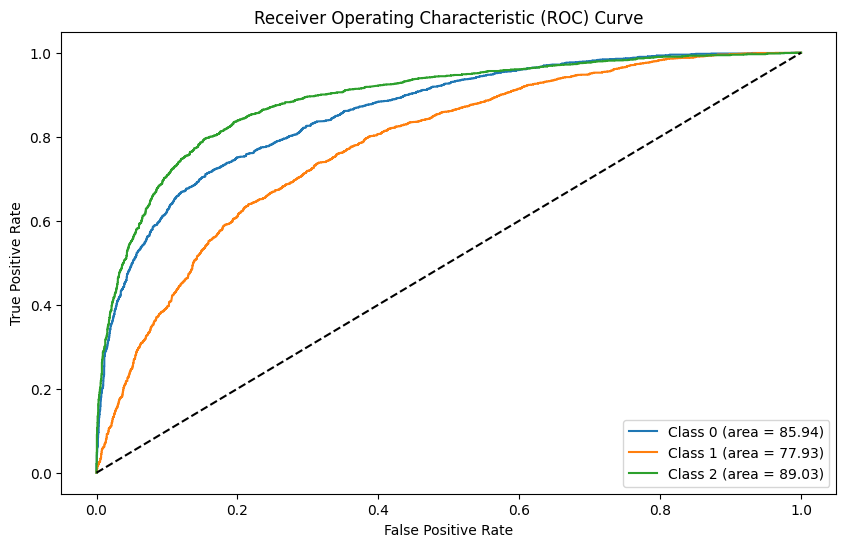

Accuracy Score: 0.6819505094614265
Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.57      0.64      1523
     Neutral       0.62      0.76      0.68      2275
    Positive       0.76      0.68      0.72      1698

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496



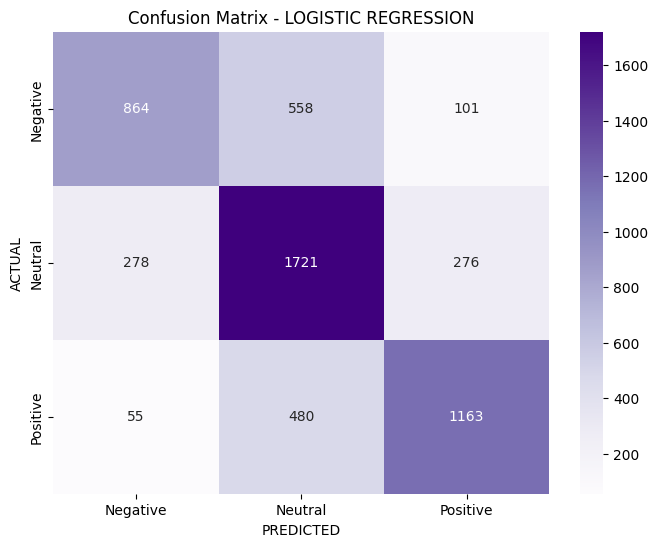

In [62]:

# Building Logistic Regression Classifier

LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0,"LR")

print("Accuracy Score:", print_acc(pred))

# Printing and exporting the classification report
report = classification_report(Test_Y, pred, target_names=['Negative','Neutral', 'Positive'])
print("Classification Report:\n", report)
with open("lr_classification_report.txt", "w") as f:
    f.write(report)

# Compute confusion matrix
cm = confusion_matrix(Test_Y, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative','Neutral', 'Positive'], 
            yticklabels=['Negative','Neutral', 'Positive'])
plt.title('Confusion Matrix - LOGISTIC REGRESSION')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.savefig("lr_conf.png")
plt.show()

---

In [20]:
%pip install joblib

In [21]:
# import pickle

# # Assuming 'LR' is your trained logistic regression model
# with open('lr_model.pkl', 'wb') as file:
#     pickle.dump(LR, file)

import joblib
joblib.dump(LR,'lr_model.pkl')

['lr_model.pkl']

## 2. Decisoin Tree Classfier:

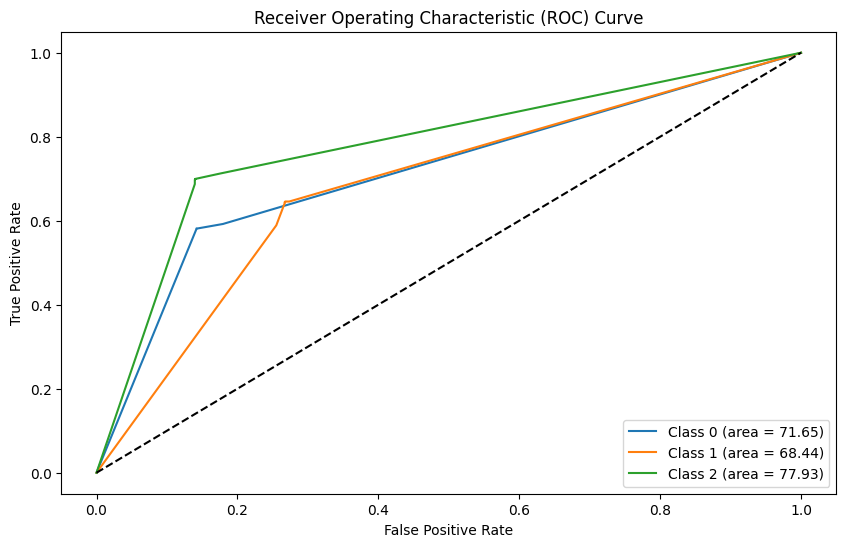

Accuracy Score: 0.643740902474527
Classification Report:
               precision    recall  f1-score   support

    Negative       0.61      0.58      0.60      1523
     Neutral       0.63      0.64      0.64      2275
    Positive       0.69      0.70      0.69      1698

    accuracy                           0.64      5496
   macro avg       0.64      0.64      0.64      5496
weighted avg       0.64      0.64      0.64      5496



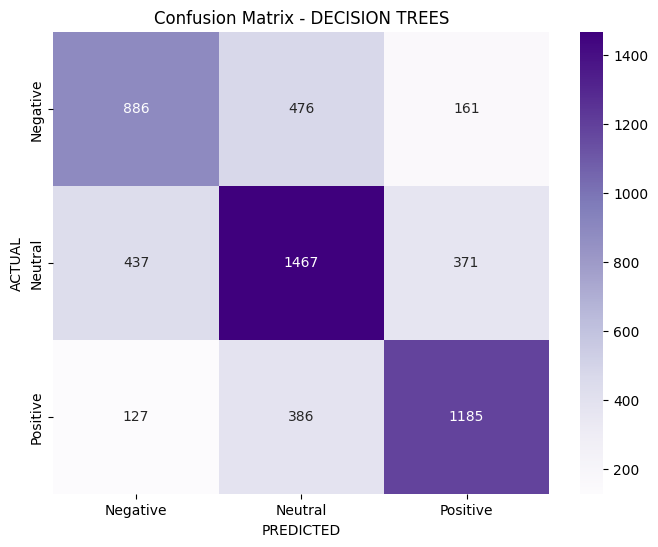

In [63]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1,"DT")

print("Accuracy Score:", print_acc(pred))

report = classification_report(Test_Y, pred, target_names=['Negative','Neutral', 'Positive'])
print("Classification Report:\n", report)
with open("dt_classification_report.txt", "w") as f:
    f.write(report)

# Compute confusion matrix
cm = confusion_matrix(Test_Y, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative','Neutral', 'Positive'], 
            yticklabels=['Negative','Neutral', 'Positive'])
plt.title('Confusion Matrix - DECISION TREES')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.savefig("dt_conf.png")
plt.show()

---

In [23]:
# import pickle

# # Assuming 'LR' is your trained logistic regression model
# with open('dt_model.pkl', 'wb') as file:
#     pickle.dump(DT, file)

import joblib
joblib.dump(DT,'dt_model.pkl')

['dt_model.pkl']

## 3. Random Forest Classfier:

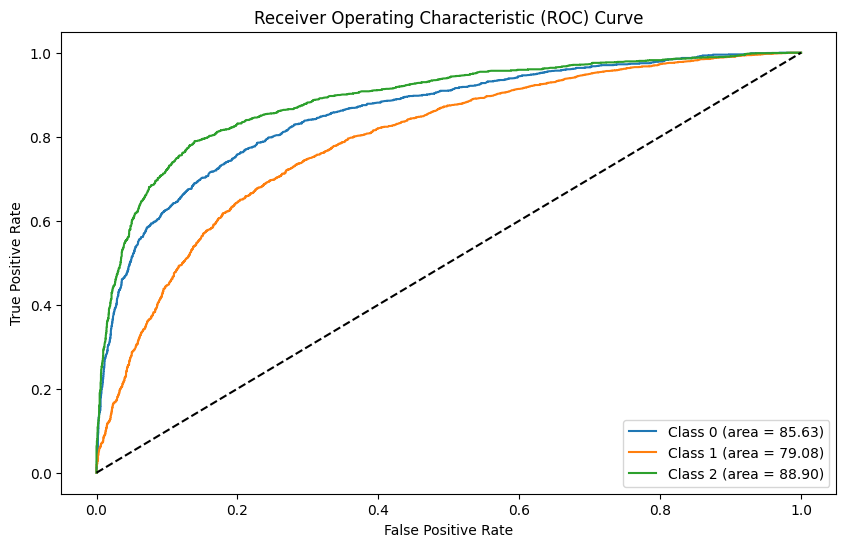

Accuracy Score: 0.6961426491994177
Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.57      0.64      1523
     Neutral       0.65      0.75      0.69      2275
    Positive       0.74      0.74      0.74      1698

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.70      0.69      5496



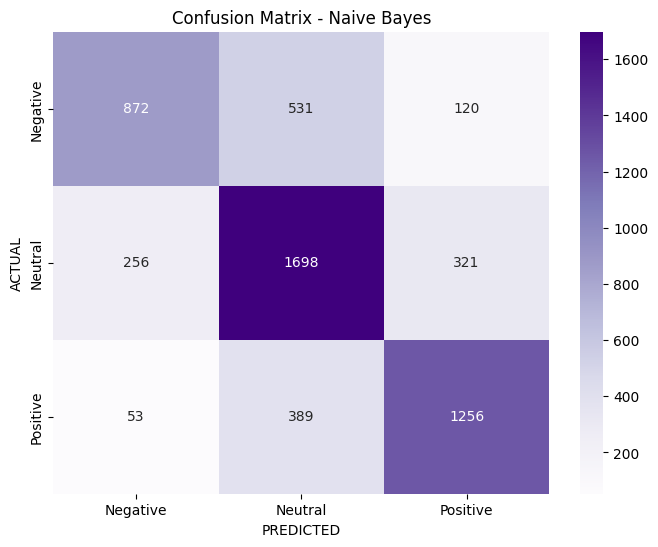

In [65]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier(n_estimators=1000)
RF = RF_model.fit(Train_X, Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,2,'RF')

print("Accuracy Score:", print_acc(pred))

report = classification_report(Test_Y, pred, target_names=['Negative','Neutral', 'Positive'])
print("Classification Report:\n", report)
with open("rf_classification_report.txt", "w") as f:
    f.write(report)

# Compute confusion matrix
cm = confusion_matrix(Test_Y, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative','Neutral', 'Positive'], 
            yticklabels=['Negative','Neutral', 'Positive'])
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.savefig("rf_conf.png")
plt.show()

---

In [25]:
# import pickle

# # Assuming 'LR' is your trained logistic regression model
# with open('rf_model.pkl', 'wb') as file:
#     pickle.dump(RF, file)

import joblib
joblib.dump(RF,'rf_model.pkl')

['rf_model.pkl']

## 4. Naive Bayes Classfier:

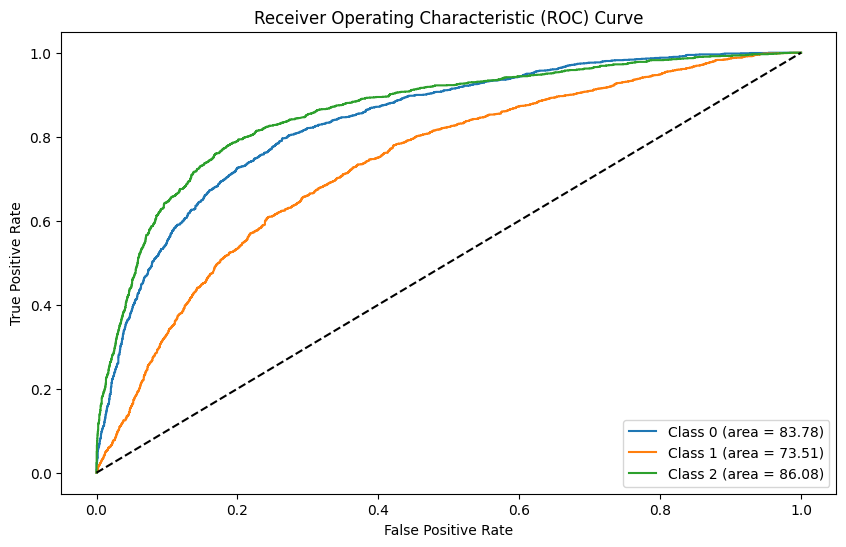

Accuracy Score: 0.6346433770014556
Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.43      0.54      1523
     Neutral       0.56      0.79      0.66      2275
    Positive       0.74      0.61      0.67      1698

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.62      5496
weighted avg       0.66      0.63      0.63      5496



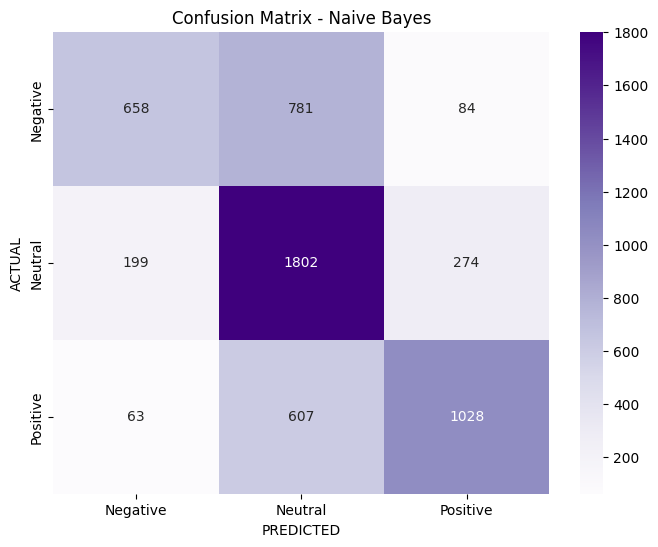

In [64]:

# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,3,'NB')
print("Accuracy Score:", print_acc(pred))

report = classification_report(Test_Y, pred, target_names=['Negative','Neutral', 'Positive'])
print("Classification Report:\n", report)
with open("nb_classification_report.txt", "w") as f:
    f.write(report)

# Compute confusion matrix
cm = confusion_matrix(Test_Y, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negative','Neutral', 'Positive'], 
            yticklabels=['Negative','Neutral', 'Positive'])
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.savefig("nb_conf.png")
plt.show()

---

In [27]:
# import pickle

# # Assuming 'LR' is your trained logistic regression model
# with open('nb_model.pkl', 'wb') as file:
#     pickle.dump(NB, file)


import joblib
joblib.dump(NB,'nb_model.pkl')

['nb_model.pkl']

## 4. Model Evaluation

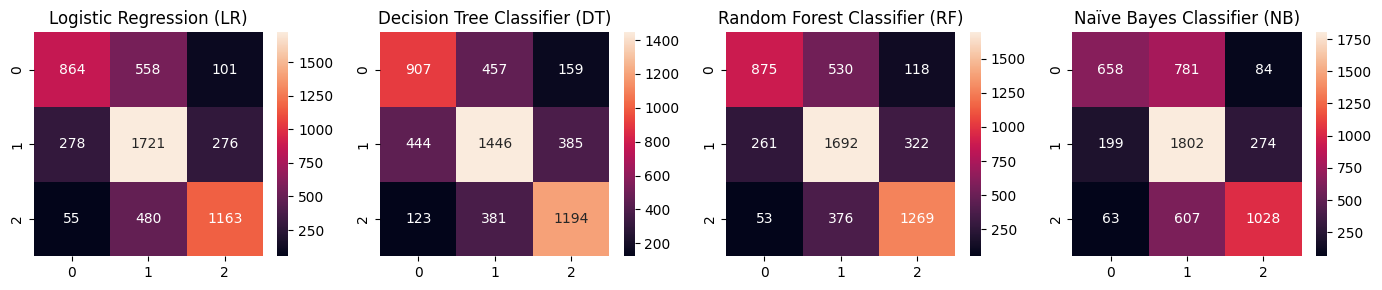

In [46]:
#Plotting Confusion-Matrix of all the predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"

def conf_mat_plot(all_models):
    plt.figure(figsize=[14,3*math.ceil(len([all_models])/4)])

    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(1,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(Test_X)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, fmt='.0f') #vmin=0,vmax=5,cmap='BuGn'
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB])

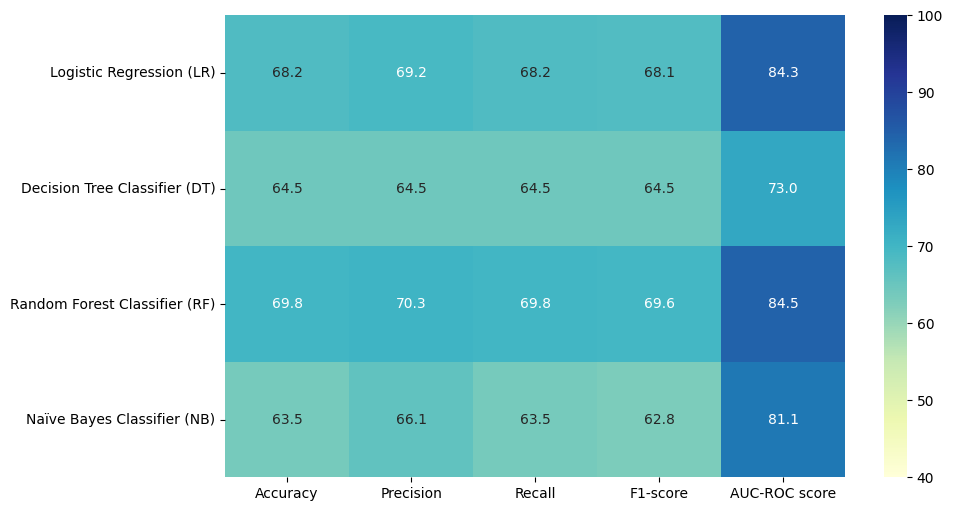

In [29]:
#Comparing all the models Scores

#plt.figure(figsize=[12,5])
sns.heatmap(Evaluation_Results, annot=True, vmin=40, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

---

## 5. Sample Test

In [30]:
def preprocess_input(text, vectorizer):
    return vectorizer.transform([text])


for i in range(3):
  # Example new input text
  new_text = input("Enter tweet")

  print("Predicting for tweet:\n",new_text)

  # Preprocess the new input
  new_text_vectorized = preprocess_input(new_text, tfidf)

  pred = LR.predict(new_text_vectorized)
  pred_prob = LR.predict_proba(new_text_vectorized)

  if(pred==2):
    pred = "POSITIVE"
  elif(pred==0):
    pred = "NEGATIVE"
  else:
    pred = "NEUTRAL"
  print("Prediction LR:", pred)
  print("Prediction probabilities LR:", pred_prob)

  pred = RF.predict(new_text_vectorized)
  pred_prob = RF.predict_proba(new_text_vectorized)

  if(pred==2):
    pred = "POSITIVE"
  elif(pred==0):
    pred = "NEGATIVE"
  else:
    pred = "NEUTRAL"
  print("Prediction RF:", pred)
  print("Prediction probabilities RF:", pred_prob)

  pred = DT.predict(new_text_vectorized)
  pred_prob = DT.predict_proba(new_text_vectorized)

  if(pred==2):
    pred = "POSITIVE"
  elif(pred==0):
    pred = "NEGATIVE"
  else:
    pred = "NEUTRAL"
  print("Prediction DT:", pred)
  print("Prediction probabilities DT:", pred_prob)

  pred = NB.predict(new_text_vectorized)
  pred_prob = NB.predict_proba(new_text_vectorized)
  if(pred==2):
    pred = "POSITIVE"
  elif(pred==0):
    pred = "NEGATIVE"
  else:
    pred = "NEUTRAL"
  print("Prediction NB:", pred)
  print("Prediction probabilities NB:", pred_prob)
  print("\n")


Predicting for tweet:
 I love you all
Prediction LR: POSITIVE
Prediction probabilities LR: [[7.22273739e-06 4.33812194e-04 9.99558965e-01]]
Prediction RF: POSITIVE
Prediction probabilities RF: [[0.         0.23737554 0.76262446]]
Prediction DT: POSITIVE
Prediction probabilities DT: [[0.   0.25 0.75]]
Prediction NB: POSITIVE
Prediction probabilities NB: [[0.0201885  0.44562102 0.53419048]]


Predicting for tweet:
 i hate mondays
Prediction LR: NEGATIVE
Prediction probabilities LR: [[0.95105663 0.04400914 0.00493422]]
Prediction RF: NEGATIVE
Prediction probabilities RF: [[0.876 0.11  0.014]]
Prediction DT: NEGATIVE
Prediction probabilities DT: [[1. 0. 0.]]
Prediction NB: NEUTRAL
Prediction probabilities NB: [[0.4168462  0.55158776 0.03156603]]


Predicting for tweet:
 This is an example tweet
Prediction LR: NEUTRAL
Prediction probabilities LR: [[0.28126139 0.54354075 0.17519786]]
Prediction RF: NEUTRAL
Prediction probabilities RF: [[0.20008333 0.73425913 0.06565754]]
Prediction DT: NEUTR

In [31]:
import numpy as np

def linear_regression(X, y):
    # Add intercept term to X
    #print("Add intercept term to X")
    X = np.column_stack((np.ones(len(X)), X))
    #print(X)

    # Calculate theta using the normal equation
    #print("Calculate theta using the normal equation")
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    #print(theta)

    return theta

def predict(X, theta):
    # Add intercept term to X
    #print("Add intercept term to X while predicting")
    X = np.column_stack((np.ones(len(X)), X))
    #print(X)

    # Predict y values
    #print("Predict y values")
    y_pred = X.dot(theta)
    #print(y_pred)

    return y_pred

def mean_squared_error(y_true, y_pred):
    # Calculate mean squared error
    mse = np.mean((y_true - y_pred)**2)
    return mse

# Train the model
theta = linear_regression(Train_X, Train_Y)

# Make predictions
y_pred = predict(Test_X, theta)

# Calculate mean squared error
mse = mean_squared_error(Test_Y, y_pred)

print("Model coefficients (theta):", theta.flatten())
print("Mean Squared Error:", mse)


TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

In [ ]:
import joblib
joblib.dump(RFnewss_model,'rf_model2.pkl')

In [ ]:
def preprocess_input(text, vectorizer):
    return vectorizer.transform([text])

# Example new input text
new_text = "Example text for prediction"

# Preprocess the new input
new_text_vectorized = preprocess_input(new_text, tfidf)

pred = RFnew_model.predict(new_text_vectorized)
pred_prob = RFnew_model.predict_proba(new_text_vectorized)

print("Prediction:", pred)
print("Prediction probabilities:", pred_prob)
